# Import AFEP_parse and dependencies
AFEP_parse.py contains all the functions and library calls necessary to run the notebook

# Required modules:
- numpy
- pandas
- matplotlib
- alchemlyb (`pip install git+https://github.com/alchemistry/alchemlyb`)
- natsort (for sorting file names)
- glob (for unix-like file paths)

In [1]:
from AFEP_parse import *
import os

# User parameters

In [2]:
path='/u2/home_u2/ems363/Documents/ELIC_DCDs_Analyses/ELIC5/PEtoPG/'
filename='petopg*.fepout'

temperature = 303.15
RT = 0.00198720650096 * temperature

## IMPORTANT: Make sure the temperature above matches the temperature used to run the simulations.

In [3]:
fepoutFiles = glob(path+filename)
totalSize = 0
for file in fepoutFiles:
    totalSize += os.path.getsize(file)
print(f"Will process {len(fepoutFiles)} fepout files.\nTotal size:{np.round(totalSize/10**9, 2)}GB")

Will process 154 fepout files.
Total size:0.25GB


In [4]:
fepoutFiles = natsorted(fepoutFiles)
maxSize = 10**9 #Don't use the alchemlyb parser if larger than this size. (bytes)
decorrelate = True #Flag for decorrelation of samples
detectEQ = False #Flag for automated equilibrium detection
DiscrepancyFitting = 'LS' #ML = fit PDF of discrepancies with a normal distribution maximum likelihood estimator. LS = fit CDF of discrepancies with a normal distribution least-squares estimator

# Read Data
See Shirts and Chodera (2008) for more details

"Statistically optimal analysis of samples from multiple equilibrium states" doi: 10.1063/1.2978177

In [5]:
if totalSize < maxSize:
    u_nk, affix = readAndProcess(fepoutFiles, temperature, decorrelate, detectEQ)
    
else:
    print(f"Warning: The files you are trying to read are quite large. Total size={totalSize}.\nTry the read, decorrelate, save method in the Expanded version of this notebook or increase the maxSize variable above.\nIn the future, consider using less frequent sampling (e.g. every 100 steps).")

         lambda1 = 0.041667, lambda2 = 0.05; inferring lambda_idws to be 0.033333
         lambda1 = 0.083333, lambda2 = 0.091667; inferring lambda_idws to be 0.075
         lambda1 = 0.125, lambda2 = 0.133333; inferring lambda_idws to be 0.116667
         lambda1 = 0.166667, lambda2 = 0.175; inferring lambda_idws to be 0.158333
         lambda1 = 0.208333, lambda2 = 0.216667; inferring lambda_idws to be 0.2
         lambda1 = 0.25, lambda2 = 0.258333; inferring lambda_idws to be 0.241667
         lambda1 = 0.291667, lambda2 = 0.3; inferring lambda_idws to be 0.283333
         lambda1 = 0.333333, lambda2 = 0.341667; inferring lambda_idws to be 0.325
         lambda1 = 0.375, lambda2 = 0.383333; inferring lambda_idws to be 0.366667
         lambda1 = 0.416667, lambda2 = 0.425; inferring lambda_idws to be 0.408333
         lambda1 = 0.458333, lambda2 = 0.466667; inferring lambda_idws to be 0.45
         lambda1 = 0.5, lambda2 = 0.508333; inferring lambda_idws to be 0.491667
         lamb

Decorrelating samples. Flag='True'


/u2/home_u2/ems363/miniconda3/envs/jupEnv/lib/python3.9/site-packages/alchemlyb/preprocessing/subsampling.py:135: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  return df.sort_index(0).reset_index('time').duplicated('time').any()
/u2/home_u2/ems363/miniconda3/envs/jupEnv/lib/python3.9/site-packages/alchemlyb/preprocessing/subsampling.py:133: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only.
  return df.sort_index(0).reset_index('time', name='').duplicated('time').any()
/u2/home_u2/ems363/miniconda3/envs/jupEnv/lib/python3.9/site-packages/alchemlyb/preprocessing/subsampling.py:135: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  return df.sort_index(0).reset_index('time').duplicated('time').any()
/u2/home_u2/ems363/miniconda3/envs/jupEnv/lib/python3.9/site-packages/alchemlyb/preprocessing/subsampling.py:133: FutureWarn

# Carry out MBAR Fitting and Analyses

In [8]:
u_nk = u_nk.sort_index(level=1)

In [9]:
bar = BAR()
bar.fit(u_nk)

BAR()

# Extract key features from the MBAR fitting and get ΔG
Note: alchemlyb operates in units of kT by default. We multiply by RT to convert to units of kcal/mol.

In [10]:
l, l_mid, f, df, ddf, errors = get_BAR(bar)
changeAndError = f'\u0394G = {np.round(f.iloc[-1]*RT, 1)}\u00B1{np.round(errors[-1]*RT, 3)} kcal/mol'
print(changeAndError)

ΔG = -22.2±0.185 kcal/mol


# Plot the change in free energy based on MBAR estimates

In [ ]:
# Cumulative change in kT
plt.errorbar(l, f, yerr=errors, marker='.')
plt.xlabel('lambda')
plt.ylabel('DeltaG(lambda) (kT)')
plt.title(f'Cumulative dG with accumulated errors {affix}\n{changeAndError}')
plt.savefig(f'{path}dG_cumulative_kT_{affix}.png', dpi=600)
plt.show()

# Cumulative change in kcal/mol
"""
plt.errorbar(l, f * RT, yerr=errors*RT, marker='.')
plt.xlabel('lambda')
plt.ylabel('DeltaG(lambda)(kcal/mol)')
plt.savefig(f'{path}dG_cumulative_kcal_per_mol_{affix}.png', dpi=600)
plt.show()
"""
# Per-window change in kT
plt.errorbar(l_mid, df, yerr=ddf, marker='.')
plt.xlabel('lambda')
plt.ylabel('Delta G per window (kT)')
plt.title(f'Per-Window dG with individual errors {affix}')
plt.savefig(f'{path}dG_{affix}.png', dpi=600)
plt.show()

# Per-window change in kT

plt.errorbar(l[1:-1], np.diff(df), marker='.')
plt.xlabel('lambda (L)')
plt.ylabel("dG'(L)")
plt.title(f'derivative of dG {affix}')
plt.savefig(f'{path}dG_prime_{affix}.png', dpi=600)
plt.show()


# Plot the estimated total change in free energy as a function of simulation time; contiguous subsets starting at t=0 ("Forward") and t=end ("Reverse")

In [30]:
fs, ferr, bs, berr = doConvergence(u_nk)

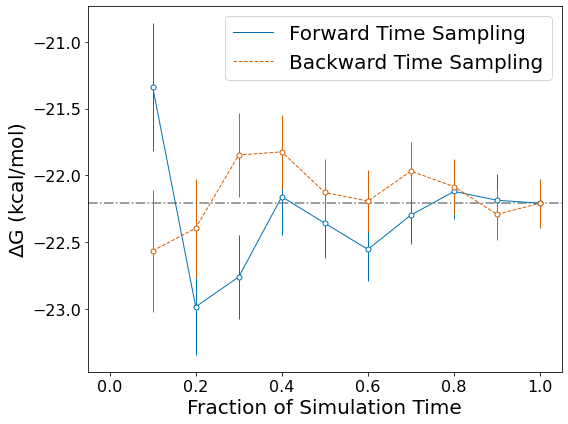

In [100]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax = convergencePlot(ax, fs*RT, ferr*RT, bs*RT, berr*RT, fwdColor='#0072B2', bwdColor='#D55E00')
ax.legend(fontsize=20)
ax.set_ylabel(r'$\rm\Delta G$ (kcal/mol)', fontsize=20)
ax.set_xlabel('Fraction of Simulation Time', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
fig.tight_layout()
plt.savefig(f'{path}convergence_{affix}.png', dpi=600)
plt.savefig(f'{path}convergence_{affix}.pdf')
plt.savefig(f'{path}FEP_convergence.pdf')

# Use an exponential estimator to assess residual discrepancies and check for hysteresis

In [11]:
l, l_mid, dG_f, dG_b = get_EXP(u_nk)

/u2/home_u2/ems363/miniconda3/envs/jupEnv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/u2/home_u2/ems363/miniconda3/envs/jupEnv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/u2/home_u2/ems363/miniconda3/envs/jupEnv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  retur

In [57]:
# fig, ax = plt.subplots(1,1, figsize=(6,6))
# ax.vlines(l_mid, np.zeros(len(l_mid)), (dG_f + np.array(dG_b))*RT, linewidth=2)

# #plt.title(f'Fwd-bwd discrepancies by lambda {affix}')
# ax.set(ylim=(-1,1))
# ax.set_xlabel(r'$\rm\lambda$', fontsize=20)
# ax.set_ylabel(r"$\rm\delta_\lambda$ (kcal/mol)", fontsize=20)
# plt.savefig(f'{path}discrepancies_{affix}.png', dpi=600)
# plt.savefig(f'{path}discrepancies_{affix}.pdf')

# Estimate and plot the Probability Density Function (PDF) for the differences shown above.

Note: you may wish to adjust the numBins parameter below depending on the number of windows you ran in your FEP calculation.

In [54]:
# X, Y, pdfX, pdfY, fitted, pdfXnorm, pdfYnorm, pdfYexpected = getPDF(dG_f, dG_b)

# #plot the data
# fig, pdfAx = plt.subplots(1, 1)
# plt.xlabel('Difference in delta-G')

# pdfAx.plot(pdfX, pdfY,  label="Estimated Distribution")
# pdfAx.set_ylabel("PDF")

# fig.set_figheight(5)
# pdfAx.title.set_text(f"Estimated PDF (fwd-bkwd)\nSkewness: {np.round(skew(X),2)}\nPopulation parameters: Mean={np.round(np.average(X),3)}, Stdv={np.round(np.std(X),3)}")
# plt.savefig(f"{path}pdf_{affix}.png", dpi=600)


# plt.show()

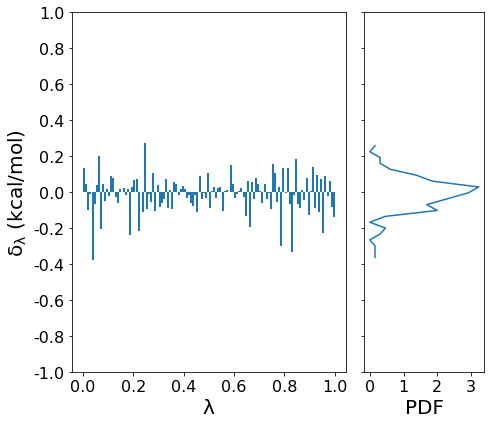

In [99]:
fig, (dAx, pdfAx) = plt.subplots(1,2, figsize=(8,6), sharey=True)
dAx.vlines(l_mid, np.zeros(len(l_mid)), (dG_f + np.array(dG_b))*RT, linewidth=2)

#plt.title(f'Fwd-bwd discrepancies by lambda {affix}')
dAx.set(ylim=(-1,1))
dAx.set_xlabel(r'$\rm\lambda$', fontsize=20)
dAx.set_ylabel(r"$\rm\delta_\lambda$ (kcal/mol)", fontsize=20)

#
X, Y, pdfX, pdfY, fitted, pdfXnorm, pdfYnorm, pdfYexpected = getPDF(dG_f, dG_b)
pdfAx.set_xlabel("PDF", fontsize=20)
pdfAx.plot(pdfY, pdfX*RT,  label="Estimated Distribution")
pdfAx.set_box_aspect(3)

#fig.set_figheight(5)
#pdfAx.title.set_text(f"Estimated PDF\nSkewness: {np.round(skew(X),2)}\nPopulation parameters: Mean={np.round(np.average(X),3)}, Stdv={np.round(np.std(X),3)}")

dAx.set_xticks(np.round(np.linspace(0,1,6),1))
dAx.set_yticks(np.round(np.linspace(-1,1,11),1))
pdfAx.set_xticks([0,1,2,3])


dAx.set_xticklabels(np.round(np.linspace(0,1,6),1),fontsize=16)
dAx.set_yticklabels(np.round(np.linspace(-1,1,11),1),fontsize=16)
pdfAx.set_xticklabels([0,1,2,3],fontsize=16)

fig.tight_layout(w_pad=-2)
plt.savefig(f'{path}discrepancies_{affix}.png', dpi=600)
plt.savefig(f'{path}discrepancies_{affix}.pdf')
plt.savefig(f'{path}hysteresis.pdf')